# Import Lib

In [51]:
# Basic
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from wordcloud import WordCloud

# Feature Enginerring
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay, accuracy_score


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\selim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import some functions

In [52]:
def summarize_dataset(data, num_head=5, num_tail=5, drop_columns=None, drop_duplicates=False):
    """
    Summarizes a DataFrame.

    Parameters:
    data (DataFrame): The DataFrame to summarize.
    num_head (int): Specifies how many rows to display from the beginning.
    num_tail (int): Specifies how many rows to display from the end.
    drop_columns (list): List of columns to drop.
    drop_duplicates (bool): Used to remove duplicates from the DataFrame.

    Returns:
    DataFrame: The processed DataFrame.
    """
    print(f"First {num_head} rows:")
    print(data.head(num_head))
    print("\n")
    
    print(f"Last {num_tail} rows:")
    print(data.tail(num_tail))
    print("\n")
    
    print("Columns:")
    print(data.columns)
    print("\n")

    print("Data Information:")
    data.info()
    print("\n")
    
    missing_values = data.isnull().sum()
    missing_columns = missing_values[missing_values > 0]
    print(f"Missing Values:\n{missing_columns}")
    print("\n")
    
    print("Statistical Summary:")
    print(data.describe())
    print("\n")
    
    print("Data Shape:")
    print(data.shape)
    print("\n")
    
    num_duplicates = data.duplicated().sum()
    print(f"Number of duplicated rows: {num_duplicates}")
    print("\n")

    if drop_duplicates:
        initial_rows = data.shape[0]  
        if drop_columns:
            data.drop_duplicates(subset=drop_columns, inplace=True)
        else:
            data.drop_duplicates(inplace=True)
        dropped_rows = initial_rows - data.shape[0]  
        print(f"Number of dropped rows: {dropped_rows}")
    return data

In [53]:
def pd_config():
    options = {
        'display': {
            'max_colwidth': 50,
            'expand_frame_repr': False,  #
            'max_rows': 14,
            'max_seq_items': 50,         
            'precision': 4,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            pd.set_option(f'{category}.{op}', value)  

if __name__ == '__main__':
    pd_config()

In [54]:
def random_split_data(X, y, train_percentage=0.7, val_percentage=0.15, test_percentage=0.15, random_state=None):
    """
    Randomly splits the data into training, validation, and test sets.

    Parameters:
    - X: Feature matrix (sparse matrix)
    - y: Labels (dense array)
    - train_percentage: Percentage of data for training (default is 0.7)
    - val_percentage: Percentage of data for validation (default is 0.15)
    - test_percentage: Percentage of data for testing (default is 0.15)
    - random_state: Seed for random number generation (default is None)

    Returns:
    - X_train, y_train: Training set
    - X_val, y_val: Validation set
    - X_test, y_test: Test set
    """
    # Split data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_percentage + test_percentage), random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_percentage/(val_percentage + test_percentage), random_state=random_state)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Import train & test data

In [55]:
train= pd.read_csv('data/train.csv').set_index('id')
test= pd.read_csv('data/test.csv').set_index('id')
data = pd.concat([train,test])
data  

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...
10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN


# First Look


In [56]:
summarize_dataset(data)

First 5 rows:
   keyword location                                               text  target
id                                                                            
1      NaN      NaN  Our Deeds are the Reason of this #earthquake M...     1.0
4      NaN      NaN             Forest fire near La Ronge Sask. Canada     1.0
5      NaN      NaN  All residents asked to 'shelter in place' are ...     1.0
6      NaN      NaN  13,000 people receive #wildfires evacuation or...     1.0
7      NaN      NaN  Just got sent this photo from Ruby #Alaska as ...     1.0


Last 5 rows:
      keyword location                                               text  target
id                                                                               
10861     NaN      NaN  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...     NaN
10865     NaN      NaN  Storm in RI worse than last hurricane. My city...     NaN
10868     NaN      NaN  Green Line derailment in Chicago http://t.co/U...     NaN
10874   

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...
10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN


In [57]:
features = train.drop("target", axis=1)  #we create our features and target 
output = train.iloc[:, -1]

In [58]:
train.shape

(7613, 4)

In [59]:
test

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...
10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...


In [60]:
train.isnull().sum()   #check how many null values


keyword       61
location    2533
text           0
target         0
dtype: int64

In [61]:

test.isnull().sum()

keyword       26
location    1105
text           0
dtype: int64

# Visualisation

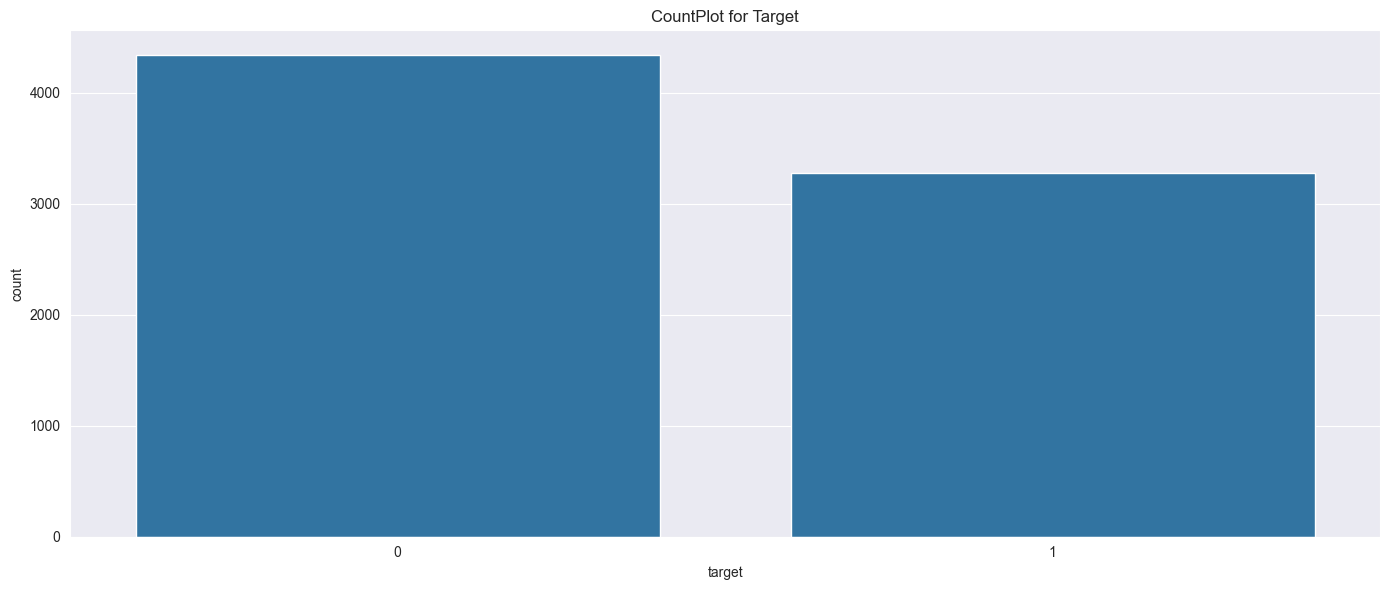

In [62]:
plt.figure(figsize=(14,6))
sns.set_style('darkgrid')
sns.countplot(data=train, x='target',legend=False)   #how many disasters and non-disasters tweets
plt.title('CountPlot for Target')
plt.tight_layout()
plt.show()


In [63]:
train['length'] = train['text'].apply(len)

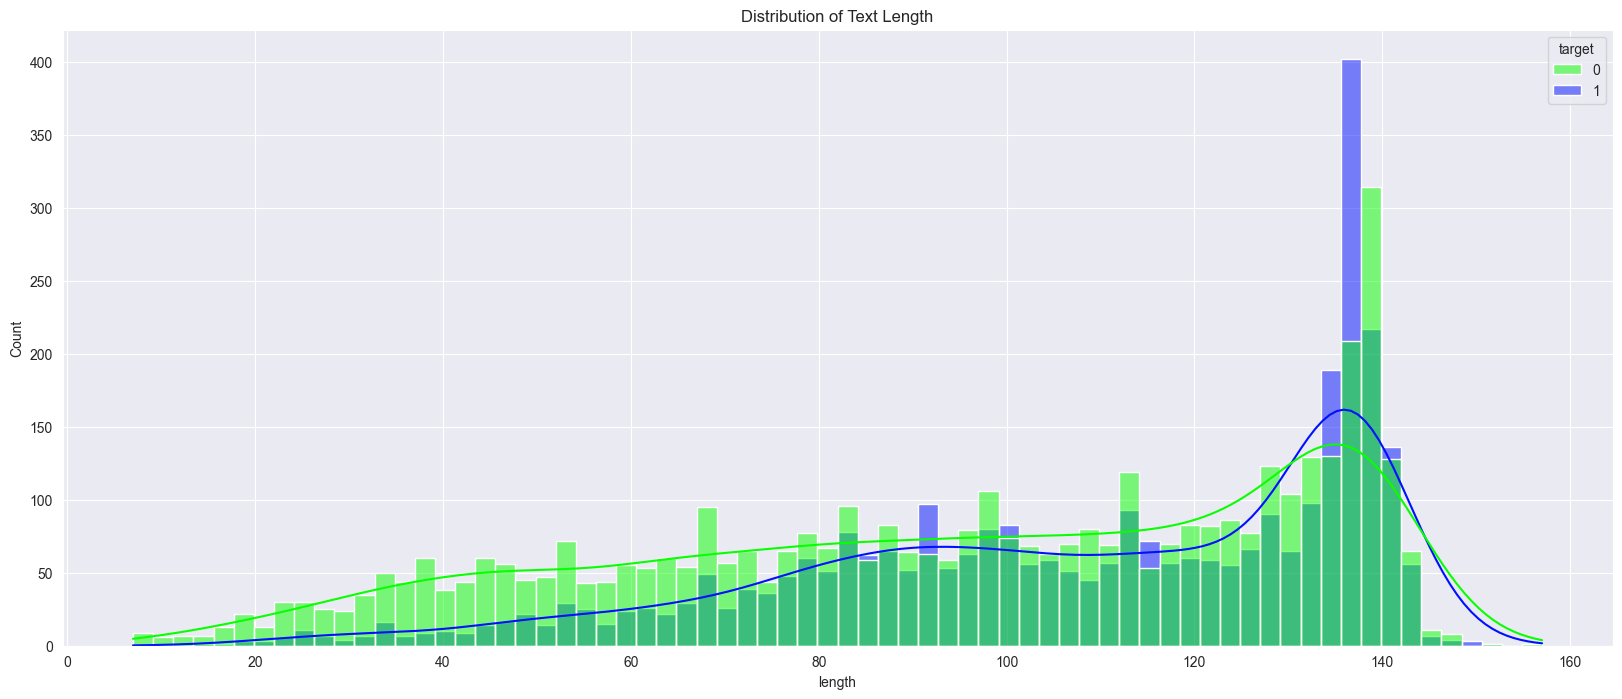

<Figure size 640x480 with 0 Axes>

In [64]:
# Plotting the distribution of text length in the 'train' DataFrame
plt.figure(figsize=(20, 8))
sns.histplot(data=train, x='length', hue='target', palette='hsv', kde=True, bins=70)
plt.title('Distribution of Text Length')      
plt.show()
plt.tight_layout()

In [65]:
 #Function to calculate the average word length of a list of strings
def avgwordlen(strlist):
    sum = []
    for i in strlist:
        sum.append(len(i))
    return sum

# Calculating average word length for disaster and non-disaster tweets
avgword_len_dis = train[train['target'] == 1]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))
avgword_len_non_dis = train[train['target'] == 0]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))

# Creating a distribution plot for average word length
group_labels = ['Disaster', 'Non-Disaster']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

# Using Plotly to create the distribution plot
fig = ff.create_distplot([avgword_len_dis, avgword_len_non_dis], group_labels, bin_size=.2, colors=colors)

# Updating layout and displaying the plot
fig.update_layout(title_text="Average Word Length in Tweets", title_x=0.5, xaxis_title="Text", yaxis_title="Density").show()

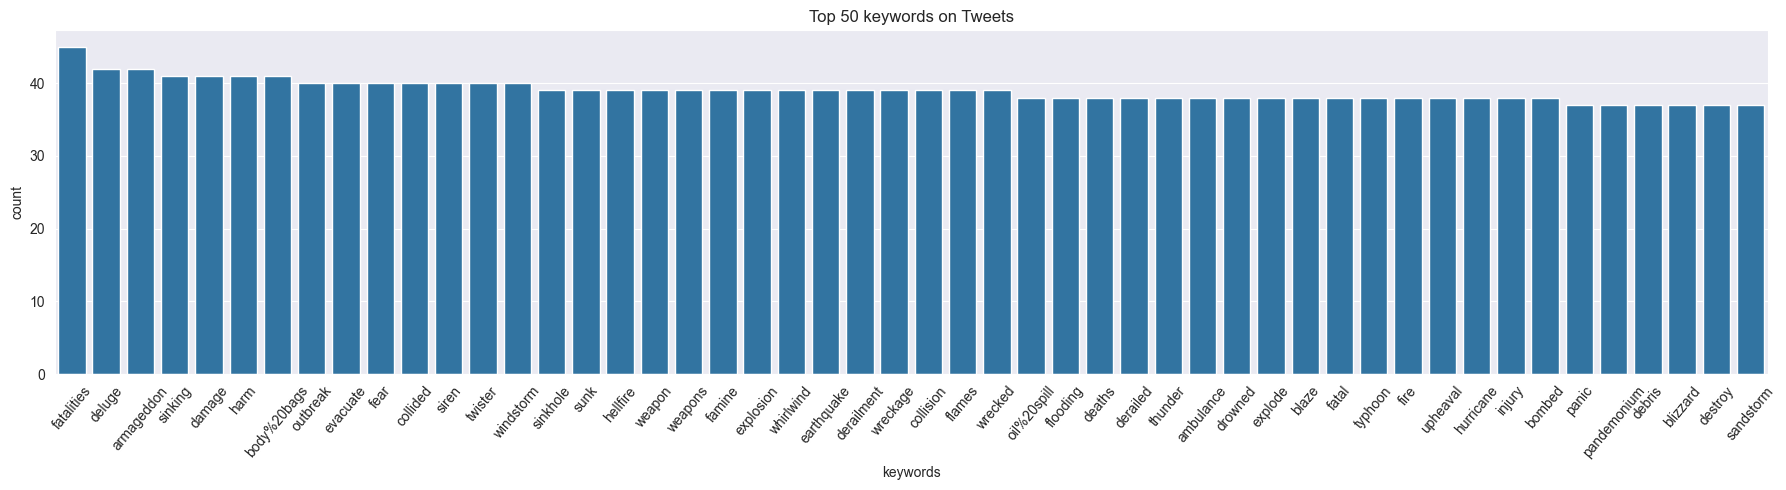

In [66]:
# Grouping by Keywords to see the count of keywords
keyword = train.groupby('keyword')['target'].count()
df_key = pd.DataFrame({'keywords':keyword.index,'count':keyword.values}).sort_values(by='count',ascending=False)

# Top 30 keywords in the Tweets.
plt.figure(figsize=(18,5))
sns.barplot(data=df_key.head(50),x='keywords',y='count')
plt.xticks(rotation = 50)
plt.title('Top 50 keywords on Tweets')
plt.tight_layout()
plt.show()

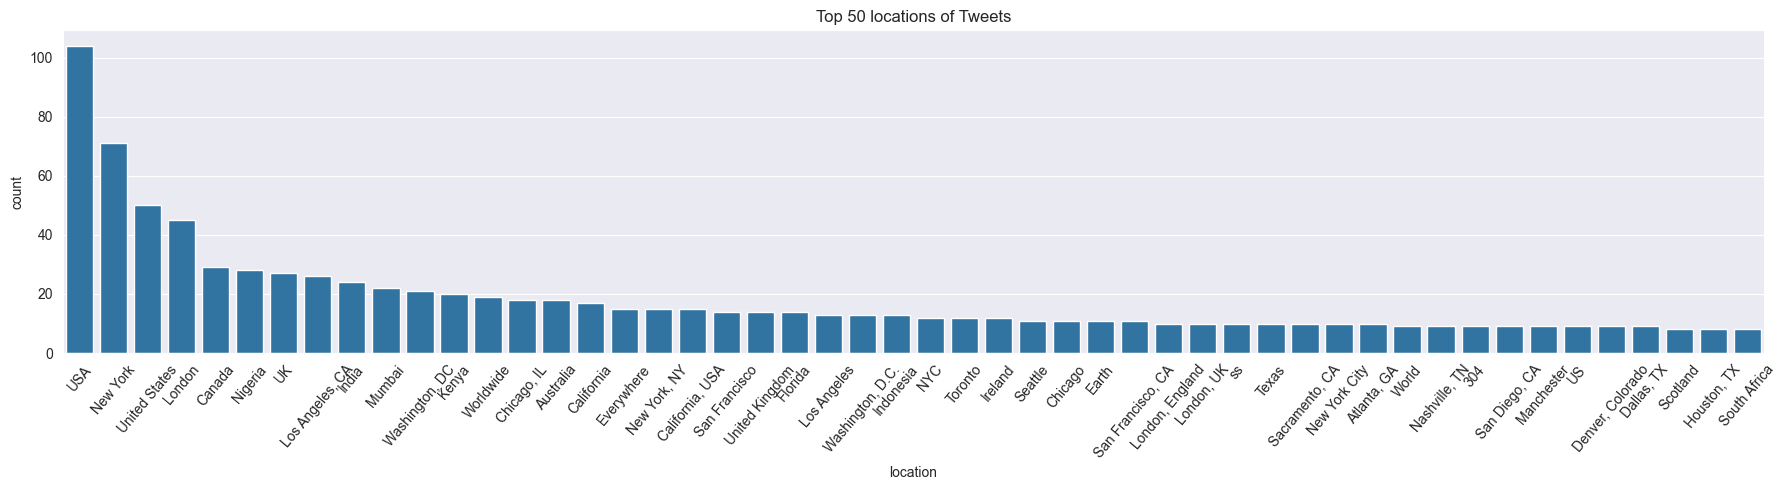

In [67]:
# Grouping by Location to find the count of each location
location = train.groupby('location')['target'].count()
df_loc = pd.DataFrame({'location':location.index,'count':location.values}).sort_values(by='count',ascending=False)

# Top 30 Location in the tweets
plt.figure(figsize=(18,5))
sns.barplot(data=df_loc.head(50),x='location',y='count')
plt.xticks(rotation = 50)
plt.title('Top 50 locations of Tweets')
plt.tight_layout()
plt.show()

# Feature Enginering

In [68]:
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove URLs
    cleaned_text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove non-alphanumeric characters  (\w includes letters, digits, and underscores) or whitespace.
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)

    # Tokenize the text ( list of words )
    tokens = nltk.word_tokenize(cleaned_text)
    
    # Apply stemming and remove  common English stopwords (e.g., "the", "and", "is")
    filtered_tokens = [stemmer.stem(token) for token in tokens if token not in stopwords.words('english')]
    
    # Join the filtered tokens into a single string
    return ' '.join(filtered_tokens)


In [69]:
testtext = train.iloc[10, :].copy()  # Make a copy to avoid modifying the original DataFrame
preprocessed_text = preprocess_text(testtext["text"])
testtext["text"],preprocessed_text   

# ('One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1402',
#  'one direct is pick fan armi direction x1402')     lınks and popular words eleminated

('Three people died from the heat wave so far',
 'three peopl die heat wave far')

In [70]:
train["text"] = train["text"].apply(preprocess_text)
test["text"] = test["text"].apply(preprocess_text)

In [71]:
disaster = ' '.join(train[train['target']==1]['text']) # Concatenating all text from tweets labeled as disasters
non_disaster =''.join(train[train['target']==0]['text']) # Concatenating all text from tweets labeled as non-disasters

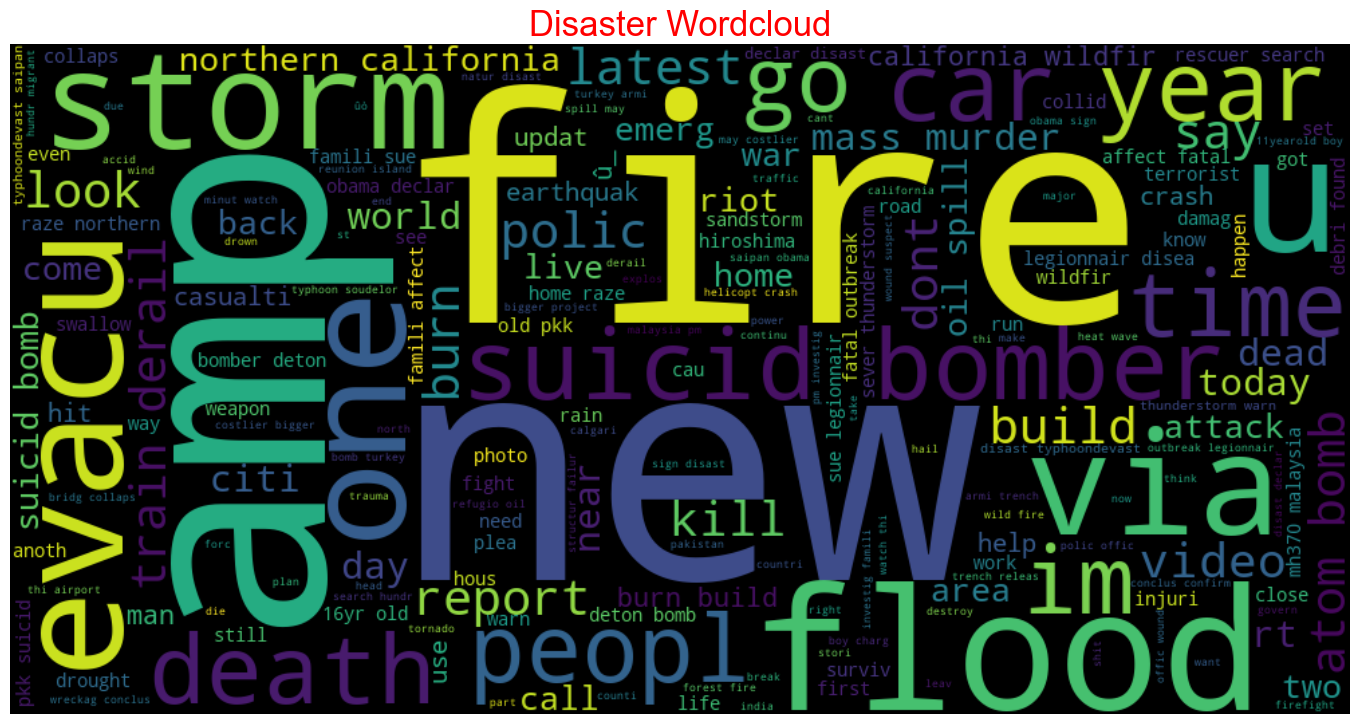

In [72]:
# Disaster Wordcloud
plt.figure(figsize=(14,7))
wordcloud = WordCloud(width=1000,height=500).generate(disaster)
plt.imshow(wordcloud,interpolation='bilinear',cmap='Dark2')
plt.axis('off')
plt.tight_layout()
plt.title('Disaster Wordcloud',fontsize= 25,color='Red')
plt.show()

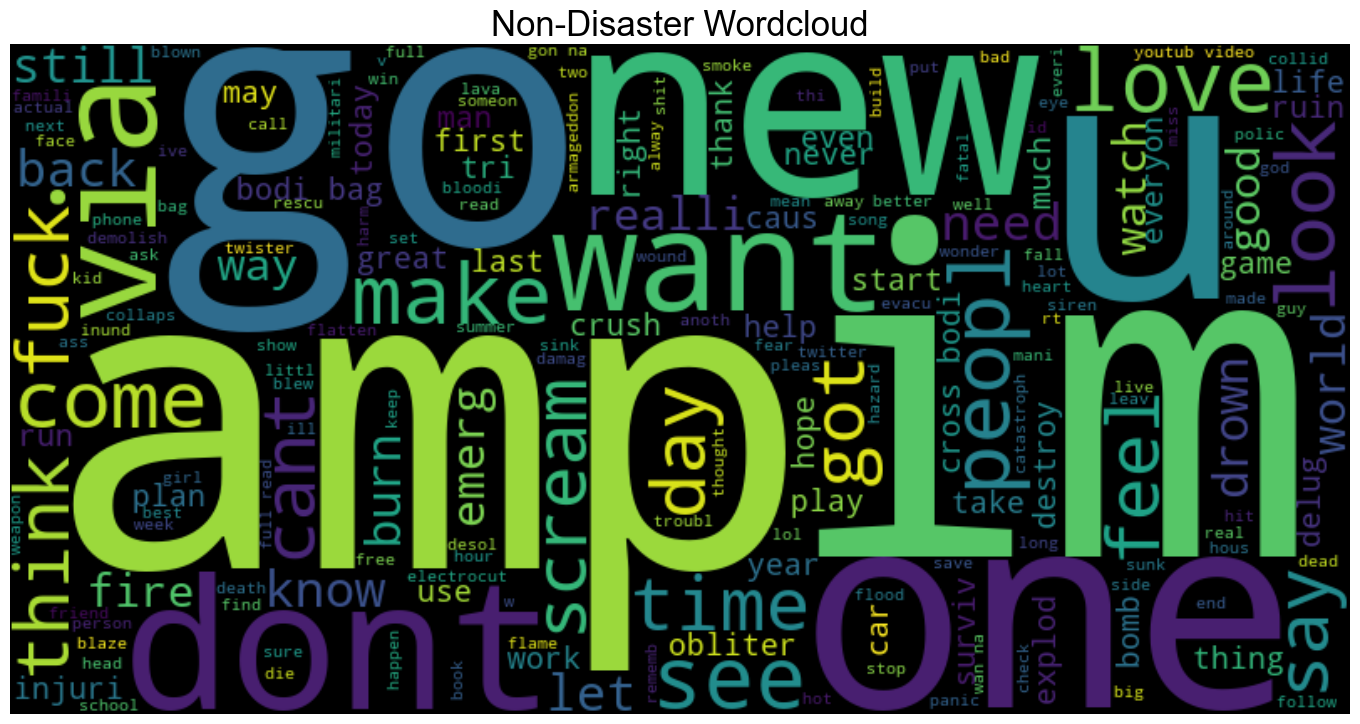

In [73]:
# Non-Disaster Wordcloud
plt.figure(figsize=(14,7),frameon=True)
wordcloud = WordCloud(width=800,height=400).generate(non_disaster)
plt.imshow(wordcloud,interpolation='bilinear',cmap='Dark2')
plt.axis('off')
plt.tight_layout()
plt.title('Non-Disaster Wordcloud',fontsize= 25,color='Black')
plt.show()

# Train Test Data


In [74]:
X = data['text']
y = train['target']
X.shape,y.shape

((10876,), (7613,))

In [75]:
train.shape,test.shape

((7613, 5), (3263, 3))

In [76]:
data

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...
10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN


In [77]:
tf = TfidfVectorizer()
data_vec=tf.fit_transform(X)
# The shape of 'data_vec' is (number_of_samples, number_of_features)
data_vec.shape
# 'number_of_samples' represents the total number of samples in the dataset
# 'number_of_features' represents the total number of unique words in the dataset after TF-IDF transformation

(10876, 27922)

data_vec=tf.fit_transform(X) transforms the input text data X into a matrix where each row corresponds to a document (or text sample),
 and each column corresponds to a unique word in the entire dataset. The values in the matrix represent the TF-IDF scores for each word in each document.

TF-IDF=TF×IDF

where:

TF (Term Frequency) is the number of times a term (word) appears in a document, normalized by the total number of terms in the document.
IDF (Inverse Document Frequency) is a measure of how important the term is across the entire dataset. It is calculated as the logarithm of the total number of documents divided by the number of documents containing the term

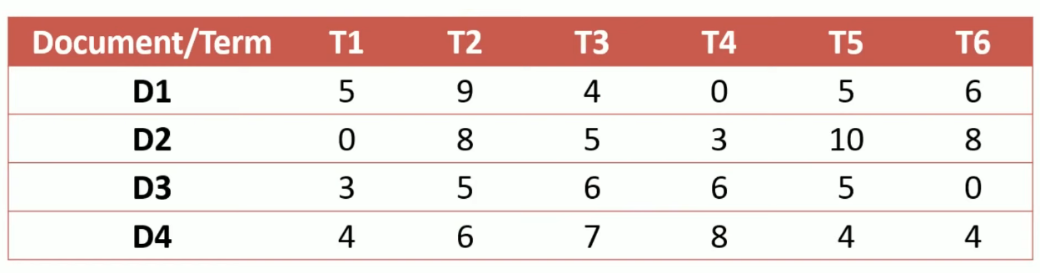

In [78]:
df_train =data_vec[:7613,:]
df_test = data_vec[7613:,:]     #y.shape 7613 ,  to match the input shape and output shape we slice our vectorized data on 7612

In [79]:
print(df_train.shape)
print(y.shape)


(7613, 27922)
(7613,)


In [80]:
X_train, y_train, X_val, y_val, X_test, y_test = random_split_data(df_train, y)

# Models

In [81]:

lr = LogisticRegression()
gbc = GradientBoostingClassifier()
xgb = XGBClassifier()

# Logistic Regression

In [82]:
#train the model using the  training data
sns.set_style('white')
pipe_lr = make_pipeline(lr)
pipe_lr.fit(X_train,y_train)

Pipeline(steps=[('logisticregression', LogisticRegression())])

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       644
           1       0.83      0.67      0.74       498

    accuracy                           0.80      1142
   macro avg       0.80      0.78      0.79      1142
weighted avg       0.80      0.80      0.79      1142



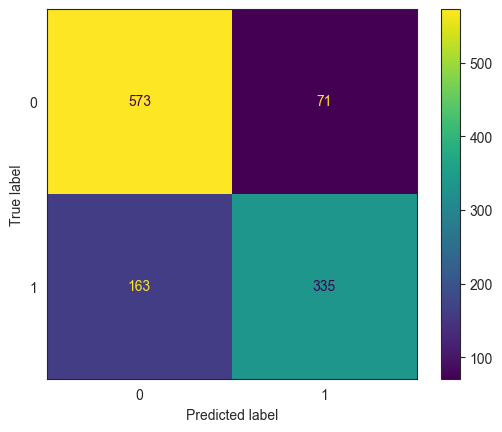

In [83]:
#for validation set
pred = pipe_lr.predict(X_val)
print(classification_report(y_val,pred))
ConfusionMatrixDisplay(confusion_matrix(y_val,pred)).plot()
score_lr = accuracy_score(y_val,pred)

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       652
           1       0.84      0.62      0.71       490

    accuracy                           0.78      1142
   macro avg       0.80      0.76      0.77      1142
weighted avg       0.79      0.78      0.78      1142



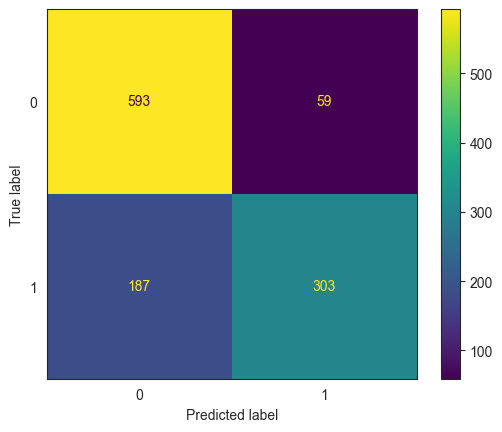

In [84]:
#for test set
pred = pipe_lr.predict(X_test)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
score_lr = accuracy_score(y_test,pred)

# Gradiant Boosting Classifier

In [85]:
#train the model
pipe_grd = make_pipeline(gbc)
pipe_grd.fit(X_train,y_train)

Pipeline(steps=[('gradientboostingclassifier', GradientBoostingClassifier())])

              precision    recall  f1-score   support

           0       0.71      0.87      0.78       644
           1       0.77      0.55      0.64       498

    accuracy                           0.73      1142
   macro avg       0.74      0.71      0.71      1142
weighted avg       0.74      0.73      0.72      1142



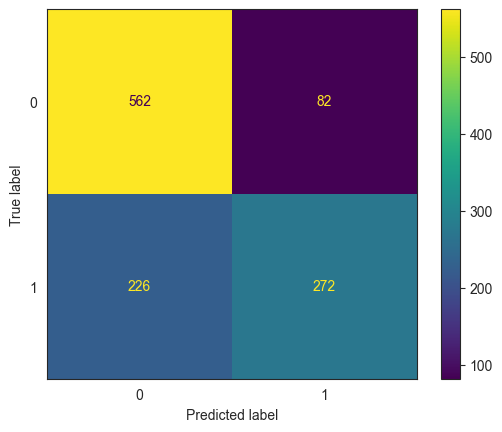

In [86]:
#for validation set
pred = pipe_grd.predict(X_val)
print(classification_report(y_val,pred))
ConfusionMatrixDisplay(confusion_matrix(y_val,pred)).plot()
score_grd = accuracy_score(y_val,pred)

              precision    recall  f1-score   support

           0       0.73      0.92      0.81       652
           1       0.83      0.54      0.66       490

    accuracy                           0.76      1142
   macro avg       0.78      0.73      0.74      1142
weighted avg       0.77      0.76      0.75      1142



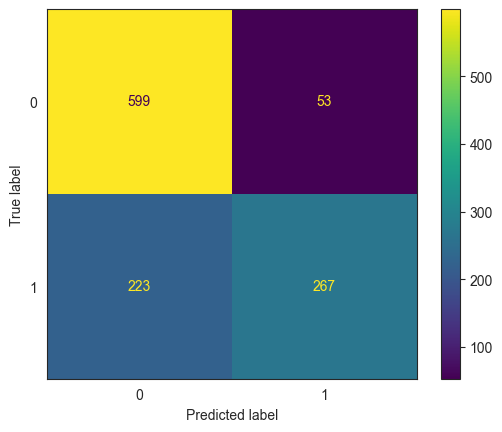

In [87]:
#for test set
pred = pipe_grd.predict(X_test)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
score_grd = accuracy_score(y_test,pred)

# XG Boost

In [88]:
#train the model
pipe_xgb = make_pipeline(xgb)
pipe_xgb.fit(X_train,y_train)

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       644
           1       0.80      0.68      0.74       498

    accuracy                           0.79      1142
   macro avg       0.79      0.78      0.78      1142
weighted avg       0.79      0.79      0.78      1142



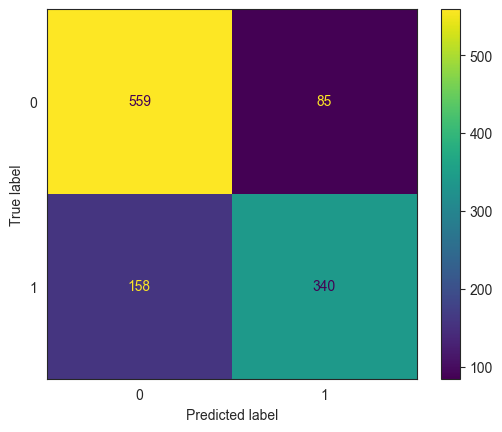

In [89]:
#for validation set
pred = pipe_xgb.predict(X_val)
print(classification_report(y_val,pred))
ConfusionMatrixDisplay(confusion_matrix(y_val,pred)).plot()
score_xgb = accuracy_score(y_val,pred)

              precision    recall  f1-score   support

           0       0.77      0.89      0.82       652
           1       0.81      0.64      0.71       490

    accuracy                           0.78      1142
   macro avg       0.79      0.76      0.77      1142
weighted avg       0.79      0.78      0.78      1142



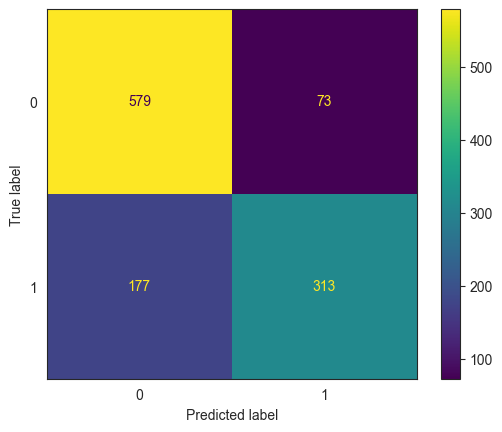

In [90]:
#for test set
pred = pipe_xgb.predict(X_test)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
score_xgb = accuracy_score(y_test,pred)

# Voting Classifier

              precision    recall  f1-score   support

           0       0.75      0.92      0.83       652
           1       0.84      0.60      0.70       490

    accuracy                           0.78      1142
   macro avg       0.80      0.76      0.76      1142
weighted avg       0.79      0.78      0.77      1142



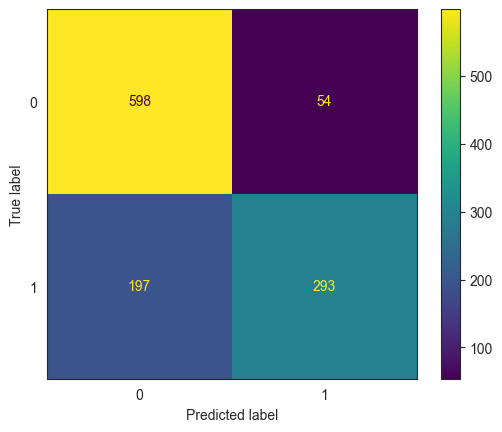

In [91]:
pipe_vt = VotingClassifier(estimators=[('lr',lr),('gbc',gbc),('xg',xgb)],voting='hard')
pipe_vt.fit(X_train,y_train)
pred_vt = pipe_vt.predict(X_test)
print(classification_report(y_test,pred_vt))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred_vt)).plot()
score_vt = accuracy_score(y_test,pred_vt)

In [92]:
data = {'models': ['Logistic Regression','Gradient Boosting Classifier','XGB Classifier','Voting Classifier'],
        'Score': [score_lr,score_grd,score_xgb,score_vt]}
df =pd.DataFrame(data)
df['Score'] =df['Score']*100
df.sort_values(by='Score',ascending=False).reset_index(drop=True)

,models,Score
0,Logistic Regression,78.4588
1,XGB Classifier,78.1086
2,Voting Classifier,78.0210
3,Gradient Boosting Classifier,75.8319


In [93]:
# Set the layers for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validation scores
scores_lr = cross_val_score(lr, X_train, y_train, cv=cv, scoring='accuracy')
scores_grd = cross_val_score(gbc, X_train, y_train, cv=cv, scoring='accuracy')
scores_xgb = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='accuracy')

#output
print("Logistic Regression Cross-Validation Score: {:.2f}% (+/- {:.2f}%)".format(scores_lr.mean() * 100, scores_lr.std() * 2 * 100))
print("Gradient Boosting Cross-Validation Score: {:.2f}% (+/- {:.2f}%)".format(scores_grd.mean() * 100, scores_grd.std() * 2 * 100))
print("XGB Classifier Cross-Validation Score: {:.2f}% (+/- {:.2f}%)".format(scores_xgb.mean() * 100, scores_xgb.std() * 2 * 100))


Logistic Regression Cross-Validation Score: 79.53% (+/- 2.55%)
Gradient Boosting Cross-Validation Score: 74.85% (+/- 3.77%)
XGB Classifier Cross-Validation Score: 77.18% (+/- 2.58%)


The fact that the scores do not change indicates that the model have a good generalization.
Additionally, a low standard deviation indicates that the stability is high. Thus, we can say that the most stable model is LR.